In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [224, 224]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 5

print(ROOT_PATH)

/aiffel/aiffel


In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person774_virus_1403.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0290-0001.jpeg


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1079
Pneumonia images count in training set: 3106


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  True


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
def augment(image, label):
    # 좌우 반전
    image = tf.image.random_flip_left_right(image)

    # 상하 반전
    image = tf.image.random_flip_up_down(image)

    # 회전
    angle = tf.random.uniform([], -10, 10)
    image = tf.image.rot90(image, angle)

    # 크기 조정
    size = tf.random.uniform([], 0.9, 1.1)
    image = tf.image.resize(image, (int(size * image.shape[1]), int(size * image.shape[0])))

    # 잡음 추가
    noise = tf.random_normal(image.shape, mean=0.0, stddev=0.05)
    image = image + noise

    return image, label

In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

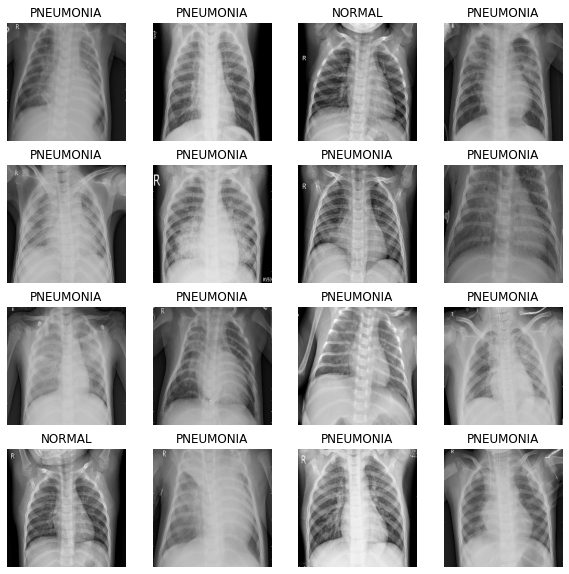

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [19]:
import tensorflow as tf

def residual_block(x, filters, kernel_size=3, strides=1):
    y = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)

    y = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
    y = tf.keras.layers.BatchNormalization()(y)

    if strides > 1 or x.shape[-1] != filters:
        x = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    y = tf.keras.layers.Add()([x, y])
    y = tf.keras.layers.ReLU()(y)

    return y

def build_resnet18(input_shape=(224, 224, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64, strides=1)
    x = residual_block(x, filters=64, strides=1)
    
    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128, strides=1)
    
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256, strides=1)
    
    x = residual_block(x, filters=512, strides=2)
    x = residual_block(x, filters=512, strides=1)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [21]:
from tensorflow.keras import optimizers
optimizer = tf.keras.optimizers.Adam(0.001)

with tf.device('/GPU:0'):
    model = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
from tensorflow.keras import callbacks
with tf.device('/GPU:0'):
    check_point_cb = callbacks.ModelCheckpoint('resnet18_model.h5', save_best_only=True)
    early_stopping_cb = callbacks.EarlyStopping(patience=2, monitor='val_loss',
                                  restore_best_weights=True)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[check_point_cb, early_stopping_cb]
    )

Epoch 1/5
261/261 [==============================] - 75s 203ms/step - loss: 13.5408 - accuracy: 0.7883 - precision: 0.9328 - recall: 0.7703 - val_loss: 3.2057 - val_accuracy: 0.7654 - val_precision: 0.7648 - val_recall: 0.9870
Epoch 2/5
261/261 [==============================] - 52s 201ms/step - loss: 1.7984 - accuracy: 0.8506 - precision: 0.9508 - recall: 0.8423 - val_loss: 2.3328 - val_accuracy: 0.2587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
261/261 [==============================] - 53s 203ms/step - loss: 0.8464 - accuracy: 0.8906 - precision: 0.9635 - recall: 0.8861 - val_loss: 0.9193 - val_accuracy: 0.8548 - val_precision: 0.9655 - val_recall: 0.8340
Epoch 4/5
261/261 [==============================] - 54s 206ms/step - loss: 0.7588 - accuracy: 0.8915 - precision: 0.9625 - recall: 0.8882 - val_loss: 2.9564 - val_accuracy: 0.2606 - val_precision: 1.0000 - val_recall: 0.0026
Epoch 5/5
261/261 [==============================] - 56s 214ms/step - loss: 0.6786 - ac

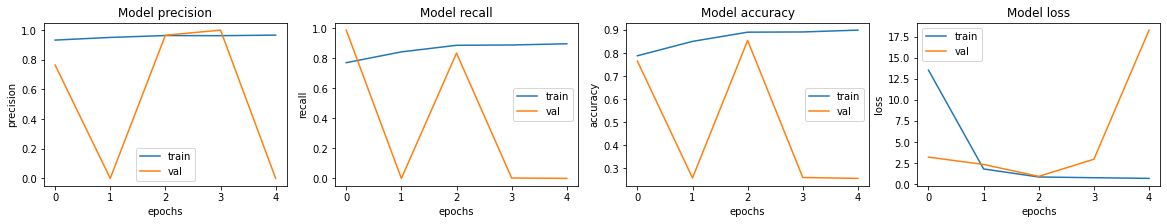

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 116ms/step - loss: 0.9810 - accuracy: 0.7612 - precision: 0.7625 - recall: 0.8974
Loss: 0.9809504747390747,
Accuracy: 0.7612179517745972,
Precision: 0.7625272274017334,
Recall: 0.8974359035491943
